In [38]:
from skimage import io, morphology, color, util, filters, draw
from scipy import stats
import numpy as np
from PIL import Image
import pandas as pd
import sknw
import argparse

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style="darkgrid", palette="Set2")
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [39]:
img_folder = "data/"
overview_file = "image_overview.csv"
pixels_per_hyphal_element = 50
n_hours = 24
small_object_limit = 10000
small_object_limit_skeleton = 1000
median_filter_kernel = 5
fluorescence_dim = 2

genotype = ["spaa","wt"]

In [40]:
def import_fluorescent_img(fname, fluorescence_dim):
    
    fl_img  = io.imread(fname)
    fl_img = fl_img[:,:,fluorescence_dim]
    fl_img = util.img_as_ubyte(fl_img)
    
    return fl_img

def preprocess_image(fluorescent_img, threshold, small_object_limit, small_object_limit_skeleton, median_filter_kernel):

    bin_img = fluorescent_img.copy()
    bin_img[bin_img >= threshold] = 255
    bin_img[bin_img < threshold] = 0

    bin_img = bin_img.astype(np.bool)

    bin_img = morphology.remove_small_objects(bin_img, min_size=small_object_limit, connectivity=2)

    bin_img = filters.median(bin_img, selem=morphology.square(median_filter_kernel))

    ske_img = morphology.skeletonize(bin_img)
    ske_img = morphology.remove_small_objects(ske_img, min_size=small_object_limit_skeleton, connectivity=2)
    
    return ske_img
    
    

def calculate_radius(p1, p2, p3):
    # from https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle/50974391#50974391
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return radius

def calculate_curvatures(points, dist=30):
    
    curvatures_all = list()
    
    for i in range(len(ps)):

        cur_curvatures = list()
        cur_line = ps[i]

        for i in range(dist, len(cur_line[:,0])-dist):

            xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
            ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

            r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
            if r is not None:
                cur_curvatures.append(1/r)
                
        curvatures_all.extend(cur_curvatures)
    
    if len(curvatures_all) != 0:
        return curvatures_all
    else:
        return None
    
def calculate_angles(graph, n_points = 10, n_min = 10):

    nodes = graph.nodes()
    angles = list()

    for i in nodes:

        if len(graph.edges(i)) != 3:
            continue

        neighbors_idx = [j for j in graph.neighbors(i)]
        neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
        neighbors_len = [len(j) for j in neighbors_pts]

        if sum(np.array(neighbors_len) > n_min) != 3:
            continue

        c = graph.nodes(data=True)[i]["o"]

        # find closest n points
        p = [0, 0, 0]
        for i in range(3):
            p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]

        # linear regression through all sets
        sets = [[0,1], [1,2], [0,2]]
        r_vals = list()
        for i in range(3):
            a, b = sets[i][0], sets[i][1]
            temp_data = np.concatenate((p[a], p[b]), axis=0)

            _, _, r_value, _, _ = stats.linregress(temp_data)
            r_squared = r_value**2

            r_vals.append(r_squared)

        best_idx = sets[np.argmax(r_vals)]
        last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]

        # create two lines, one through two best sets and one through last set. 
        temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
        slope1, _, _, _, _ = stats.linregress(temp_data)
        slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
        
        if np.isnan(slope1): slope1=1000
        if np.isnan(slope2): slope2=1000

        alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
        angle = alpha - beta
        #angle = (m1 - m2)*180/3.14
        if angle < 0:
            angle = -angle
        if angle > 90:
            angle = 180 - angle

        angles.append(angle)
        
    return angles

def box_fractal_dim(Z, threshold=0.9):
    # From https://github.com/rougier/numpy-100 (#87)
    # Only for 2d image
    assert(len(Z.shape) == 2)
    
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def get_dist_params(measure, data, angle_max=40):
    if measure == "curvature":
        dist_name = "gamma"
        dist = getattr(stats, dist_name)
        max_curv = max(data)
        data = [angle_max*i/max_curv for i in data]
        fit = dist.fit(data)
        p = [fit[0], fit[2]] #a, scale in scipy
    elif measure == "branching":
        dist_name = "beta"
        max_angle = max(data)
        data = [i/max_angle for i in data]
        dist = getattr(stats, dist_name)
        p = dist.fit(data)[0:2] #a, b in scipy
    return p


# Read file

In [43]:
img_overview = pd.read_csv(img_folder+overview_file)

if genotype != ["all"]:
    img_overview = img_overview.loc[(img_overview["gene"].isin(genotype))].reset_index(drop=True)
    
img_overview

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.png,wt
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.png,wt
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.jpg,wt
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.jpg,wt
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.jpg,wt
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.jpg,wt
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.jpg,wt
7,7,7_brightfield.jpg,7_fluorescence.jpg,25,7_target.jpg,wt
8,12,11_brightfield_spaA.jpg,11_fluorescence_spaA.jpg,15,11_target.jpg,spaa
9,13,12_brightfield_spaA.jpg,12_fluorescence_spaA.jpg,15,12_target.jpg,spaa


# Extract features from images

In [44]:
branching_freqs = list()
curvatures_all = list()
angles_all = list()
internodal_all = list()
box_counting_dims_all = list()

for idx in range(len(img_overview)):


    fluorescent_img = import_fluorescent_img(img_folder + img_overview.at[idx,"target_img_fname"], fluorescence_dim=fluorescence_dim)
    
    skeleton = preprocess_image(fluorescent_img, img_overview.at[idx,"binary_threshold"],
                                small_object_limit, small_object_limit_skeleton, median_filter_kernel)
    
    # build graph from skeleton
    graph = sknw.build_sknw(skeleton)

    # draw node by o
    nodes = graph.nodes()
    bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
    ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
    
    ps = list()
    internodal_lengths = list()

    for (s,e) in graph.edges():
        ps.append(graph[s][e]['pts'].astype(np.int32))
        
        if len([j for j in graph.neighbors(s)]) == 3 and len([j for j in graph.neighbors(s)]) == 3:
            internodal_lengths.append(len(graph[s][e]['pts'].astype(np.int32)))
        
    curvatures = calculate_curvatures(ps)
        
    branch_occurence = (len(bs))/graph.size(weight="weight")    
    n_hyphal_elements = (graph.size(weight="weight"))/pixels_per_hyphal_element
    
    curvatures_all.append(curvatures)
    branching_freqs.append(branch_occurence*pixels_per_hyphal_element/n_hours)
    
    angles = calculate_angles(graph)
    angles_all.append(angles)
    
    internodal_all.append(internodal_lengths)
    
    box_counting_dims_all.append(box_fractal_dim(skeleton))

# Investigate distributions

In [45]:
results = img_overview.loc[:, ["img_index", "gene"]].copy()

results["branching_freqs"] = branching_freqs
results["box_counting_dim"] = box_counting_dims_all
results["mean_curvature"] = [np.mean(x) for x in curvatures_all]
results["mean_angle"] = [np.mean(x) for x in angles_all]

results = results.loc[:, ["gene", "branching_freqs", "box_counting_dim", "mean_curvature", "mean_angle"]]

results

,gene,branching_freqs,box_counting_dim,mean_curvature,mean_angle
0,wt,0.015759,1.302626,0.004254,73.331330
1,wt,0.013036,1.410648,0.005425,74.954610
2,wt,0.014245,1.170156,0.004981,74.383899
3,wt,0.018739,1.448176,0.004432,71.449223
4,wt,0.021226,1.315881,0.004726,72.797602
5,wt,0.018071,1.449200,0.004492,72.271448
6,wt,0.019359,1.393574,0.004061,72.141909
7,wt,0.014972,1.389426,0.006531,69.912388
8,spaa,0.021577,1.500870,0.005928,69.881001
9,spaa,0.015466,1.262643,0.005449,74.655214


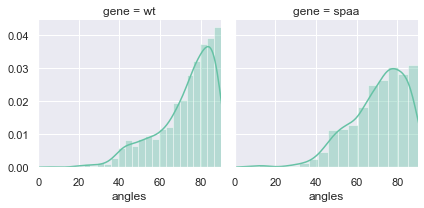

In [46]:
angle_df = img_overview.copy()
angle_df["angles"] = angles_all
angle_df = angle_df.loc[:, ["gene", "angles"]]
angle_df = angle_df.explode('angles')

angle_df["angles"] = angle_df["angles"].astype(float)

g = sns.FacetGrid(data=angle_df, col="gene", xlim=(0, 90))
g.map(sns.distplot, "angles")

# Spider plots

In [47]:
mean_results = results.groupby("gene").mean().reset_index()
mean_results

,gene,branching_freqs,box_counting_dim,mean_curvature,mean_angle
0,spaa,0.018225,1.354341,0.005690,71.304420
1,wt,0.016926,1.359961,0.004863,72.655301


In [48]:
for column in ["branching_freqs", "box_counting_dim", "mean_curvature", "mean_angle"]:
    mean_results[column] = mean_results[column]/mean_results[column].max()
    
mean_results

,gene,branching_freqs,box_counting_dim,mean_curvature,mean_angle
0,spaa,1.000000,0.995867,1.000000,0.981407
1,wt,0.928703,1.000000,0.854647,1.000000


In [49]:
test = mean_results.transpose()
test

,0,1
gene,spaa,wt
branching_freqs,1,0.928703
box_counting_dim,0.995867,1
mean_curvature,1,0.854647
mean_angle,0.981407,1


In [50]:
test.columns = test.iloc[0, :]
test = test.iloc[1:, ]
test

gene,spaa,wt
branching_freqs,1,0.928703
box_counting_dim,0.995867,1
mean_curvature,1,0.854647
mean_angle,0.981407,1


In [51]:
growth = [0.211, 0.209, 0.345, 0.264, 0.326, 0.276]
maxgrowth = max(growth)
growth = [i/maxgrowth for i in growth]
growth

proteins = [0.573, ]

In [53]:
df

,group,branching,space_filling,curvature,angle,growth
0,chsc,0.52,0.96,0.59,0.94,0.611594
1,mcb,0.65,0.88,1.00,1.00,0.605797
2,spaa,0.38,1.00,0.56,0.96,1.000000
3,spaa_chsc,1.00,0.95,0.59,0.95,0.765217
4,spaa_gul1,0.62,0.40,0.83,0.90,0.944928
5,wt,0.36,1.00,0.47,0.99,0.800000


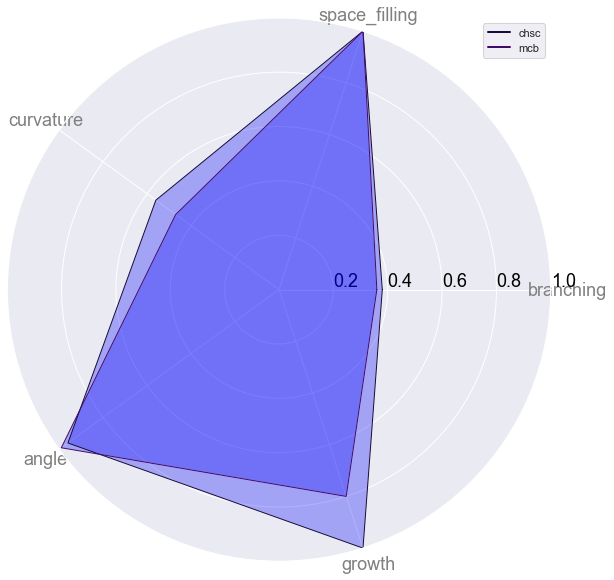

In [69]:
# Set data
df = pd.DataFrame({
'group': ['chsc','mcb','spaa','spaa_chsc','spaa_gul1','wt'],
'branching': [0.52, 0.65, 0.38, 1, 0.62, 0.36],
'space_filling': [0.96, 0.88, 1, 0.95, 0.4, 1],
'curvature': [0.59, 1, 0.56, 0.59, 0.83, 0.47],
'angle': [0.94, 1, 0.96, 0.95, 0.90, 0.99],
'growth': growth
})

df = df.loc[(df["group"].isin(genotype))].reset_index(drop=True)

# number of variable
categories=list(df)[1:]
N = len(categories)
 
plt.figure(figsize=[10,10])
ax = plt.subplot(111, polar=True)

cmap = plt.cm.inferno
colors = [cmap(0.1),cmap(0.2)]
custom_lines = list()

for i, color in enumerate(colors):
    custom_lines.append(Line2D([0], [0], color=color, lw=2))
    
for i in range(len(df.index)):
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=df.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=18)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4, 0.6, 0.8,1], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="k", size=18)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=colors[i])

    # Fill area
    ax.fill(angles, values, "b", alpha=0.3)
    
ax.legend(custom_lines, ['chsc','mcb','spaa','spaa_chsc','spaa_gul1','wt'])

In [61]:
angles

[0.0,
 1.2566370614359172,
 2.5132741228718345,
 3.7699111843077517,
 5.026548245743669,
 0.0]

df

# Export parameters for generative model to csv

In [6]:
branching_freq_avg = np.mean(branching_freqs)
curvature_params = get_dist_params("curvature", [item for sublist in curvatures_all for item in sublist]) #gamma dist, params scale
angle_params = get_dist_params("branching", [item for sublist in angles_all for item in sublist]) #beta dist, params a, b

In [7]:
export_df = pd.DataFrame([["branching_frequency", "curvature_gamma_a", "curvature_gamma_scale", "angle_beta_a", "angle_beta_b"], 
                          [branching_freq_avg] + list(curvature_params) + list(angle_params)])

export_df = export_df.rename(columns=export_df.iloc[0]).drop(export_df.index[0])

In [8]:
export_df.to_csv("graph_parameters_" + genotype + ".csv", index=False)

In [9]:
export_df

,branching_frequency,curvature_gamma_a,curvature_gamma_scale,angle_beta_a,angle_beta_b
1,0.0298208,1.65635,6.14233,3.03509,0.982454


In [10]:
curvatures_all

[[0.0005081393637602959,
  0.0010450499017690465,
  0.0021085176668002637,
  0.0021085176668002637,
  0.003170090798907293,
  0.018069398579229103,
  0.018014802834019253,
  0.018869386454758212,
  0.01874959094258179,
  0.01783550925158512,
  0.017817889109809068,
  0.017829803372090926,
  0.017829803372090926,
  0.0167317625389481,
  0.016778633698975823,
  0.016856337459939582,
  0.01563741396336871,
  0.015727765334897715,
  0.016658791571608468,
  0.014560660621244084,
  0.015492203769081895,
  0.01564021003495418,
  0.016595435111382263,
  0.015419182922467379,
  0.015419182922467379,
  0.014219916412334867,
  0.012052900494150092,
  0.0130052931461886,
  0.01178311451973099,
  0.011125075638349857,
  0.01056113634552764,
  0.009346885404647533,
  0.010303716216070909,
  0.008147491774203717,
  0.007489878183417311,
  0.007489878183417311,
  0.006796682113912234,
  0.00512040998096365,
  0.00512040998096365,
  0.00512040998096365,
  0.00435142634576337,
  0.0026178273476840427,
 

In [11]:
curvatures_all

[[0.0005081393637602959,
  0.0010450499017690465,
  0.0021085176668002637,
  0.0021085176668002637,
  0.003170090798907293,
  0.018069398579229103,
  0.018014802834019253,
  0.018869386454758212,
  0.01874959094258179,
  0.01783550925158512,
  0.017817889109809068,
  0.017829803372090926,
  0.017829803372090926,
  0.0167317625389481,
  0.016778633698975823,
  0.016856337459939582,
  0.01563741396336871,
  0.015727765334897715,
  0.016658791571608468,
  0.014560660621244084,
  0.015492203769081895,
  0.01564021003495418,
  0.016595435111382263,
  0.015419182922467379,
  0.015419182922467379,
  0.014219916412334867,
  0.012052900494150092,
  0.0130052931461886,
  0.01178311451973099,
  0.011125075638349857,
  0.01056113634552764,
  0.009346885404647533,
  0.010303716216070909,
  0.008147491774203717,
  0.007489878183417311,
  0.007489878183417311,
  0.006796682113912234,
  0.00512040998096365,
  0.00512040998096365,
  0.00512040998096365,
  0.00435142634576337,
  0.0026178273476840427,
 